## Tools

In [259]:
import pandas as pd
import re
from llama_index.embeddings.huggingface import HuggingFaceEmbedding
from IPython.display import SVG, display
import matplotlib.pyplot as plt

from utils.generic import get_driver, Models

In [89]:
driver = get_driver()

## Baseline: fulltext index search

Before running any complex experiments, we need a baseline to compare to. We believe a simple search by a keyword can be used as a baseline.
We will need to create a fulltext index on our knowledge graph - and then run it on the whole dataset.

In [3]:
create_fulltext_inde_query = """
    CREATE FULLTEXT INDEX diseaseIndex FOR (n:Disease) ON EACH [n.DiseaseName, n.Synonyms]
    OPTIONS {
        indexConfig: {
            `fulltext.analyzer`: 'english',
            `fulltext.eventually_consistent`: true
        }
    }
"""

In [7]:
with driver.session() as session:
    session.run(create_fulltext_inde_query)

In [202]:
df = pd.read_csv('../data/processed/ncbi_specific_disease.csv', sep=',')

In [84]:
def fulltext_search(disease_name, limit=1):
    with driver.session() as session:
        query = """
            CALL db.index.fulltext.queryNodes('diseaseIndex', $disease_name)
            YIELD node, score
            RETURN node.DiseaseID AS MESH_ID, node.AltDiseaseIDs as AltDiseaseIDs, node.DiseaseName AS Description, score
            LIMIT $limit
        """
        result = session.run(query, disease_name=disease_name, limit=limit)

        return [{
            'MESH_ID': record['MESH_ID'],
            'AltDiseaseIDs': record['AltDiseaseIDs'],
            'Description': record['Description'],
            'score': record['score']} for record in result
        ]

The presence of special characters in the search string will be causing issues with the Lucene query parser used by Neo4j's fulltext search. In order to make it work, we will escape them in the search query using a regexp.

In [172]:
def predict_with_fulltext_index(dataset, limit=1):
    true_values = []
    predicted_values = []

    for _, row in dataset.iterrows():
        disease_name = row['Description']
        true_mesh_id = row['MESH ID']

        disease_name_re = re.sub('[^A-Za-z0-9 ]+', '', disease_name)
        
        predicted_ids = fulltext_search(disease_name_re, limit)
        
        true_values.append({"MESH_ID": true_mesh_id, "Description": disease_name})
        predicted_values.append(predicted_ids if len(predicted_ids) > 0 else [{"MESH_ID": "Unknown", "AltDiseaseIDs": "Unknown", "Description": "Unknown"}])

    return true_values, predicted_values

In [171]:
[true_values, predicted_values] = predict_with_fulltext_index(df)

And now we can calculate the performance. However, we know that "MESH_ID" field can be either one ID ("MESH:1234") or two IDs ("MESH:1234|MESH:5678"), and vise verse the predicted values can be the same. We will treat partial match as a correct prediction, e.g. if the true label is "MESH:1234|MESH:5678" and predicted label is "MESH:1234" - this should be treated as correct. We need to write a custom function for that.

In [169]:
def extract_ids(entry):
    mesh_ids = entry['MESH_ID'].split('|') if entry['MESH_ID'] else []
    alt_disease_ids = []

    if 'AltDiseaseIDs' in entry.keys() and entry['AltDiseaseIDs'] is not None and not pd.isna(entry['AltDiseaseIDs']):
        alt_disease_ids = entry['AltDiseaseIDs'].split('|')

    all_ids = mesh_ids + alt_disease_ids
    unique_ids = list(set(all_ids)) 
    
    return unique_ids

def partial_match(true_labels, predicted_labels):
    true_set = set(extract_ids(true_labels))
    predicted_set = set(extract_ids(predicted_labels[0]))

    return not true_set.isdisjoint(predicted_set)

def custom_precision_recall_f1_accuracy(true_values, predicted_values):
    true_positive = 0
    false_positive = 0
    false_negative = 0
    
    for true_labels, predicted_labels in zip(true_values, predicted_values):
        if partial_match(true_labels, predicted_labels):
            true_positive += 1
        else:
            false_positive += 1
            false_negative += 1

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = true_positive / len(true_values) if len(true_values) > 0 else 0

    return precision, recall, f1, accuracy

In [175]:
precision, recall, f1, accuracy = custom_precision_recall_f1_accuracy(true_values=true_values, predicted_values=predicted_values)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"Accuracy: {accuracy}")

Precision: 0.52520366598778
Recall: 0.52520366598778
F1-Score: 0.52520366598778
Accuracy: 0.52520366598778


## Vector index: on DiseaseName prop

A vector index is a single-label, single-property index for nodes or a single-relationship-type, single-property index for relationships, and it can be used to index nodes or relationships by LIST<INTEGER | FLOAT> properties valid to the dimensions and vector similarity function of the index. We will start with creating a vector index for `DiseaseName` prop on `DiseaseEmbedding-BAAI-bge-small-en-v1_5` embedding and run it on the dataset with embedded `DiseaseName` property.

In [1]:
create_vector_index_query = """
    CREATE VECTOR INDEX baaiVectorIndex IF NOT EXISTS
    FOR (d:Disease)
    ON d.`DiseaseEmbedding-BAAI-bge-small-en-v1_5`
    OPTIONS {
        indexConfig: {
            `vector.dimensions`: 384,
            `vector.similarity_function`: 'cosine'
        }
    }
"""

In [5]:
with driver.session() as session:
    session.run(create_vector_index_query)

Now that we have our vector index, let us write functions to retrieve from it.

In [204]:
embed_model = HuggingFaceEmbedding(model_name=Models.BAAI_BGE_SMALL_EN_V1_5.value)

/Users/yuliana.romaniv/University/AstraZeneca/test-rag/venv/lib/python3.12/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [184]:
baai_vector_index_query = """
    CALL db.index.vector.queryNodes('baaiVectorIndex', $limit, $disease_name)
    YIELD node AS disease, score
    RETURN disease.DiseaseName AS Description, disease.DiseaseID AS MESH_ID, disease.AltDiseaseIDs AS AltDiseaseIDs, score
"""

In [178]:
def vector_index_search(query, disease_name, limit=1):
    with driver.session() as session:
        result = session.run(query, disease_name=disease_name, limit=limit)

        return [{
            'MESH_ID': record['MESH_ID'],
            'Description': record['Description'],
            'AltDiseaseIDs': record['AltDiseaseIDs'],
            'score': record['score']} for record in result
        ]

In [190]:
test_name = embed_model.get_text_embedding('Hereditary deficiency of the fifth component of complement') # should match OMIM:609536
test_vector_search_res = vector_index_search(baai_vector_index_query, test_name, limit=1)

In [191]:
test_vector_search_res

[{'MESH_ID': 'MESH:C537005',
  'Description': 'Complement component 5 deficiency',
  'AltDiseaseIDs': 'DO:DOID:8158|OMIM:609536',
  'score': 0.9679043292999268}]

In [187]:
def predict_with_vector_index(query, dataset, get_embedding, limit=1):
    true_values = []
    predicted_values = []

    for _, row in dataset.iterrows():
        disease_name = row['Description']
        true_id = row['MESH ID']
        
        predicted_mesh_id = vector_index_search(query, get_embedding(disease_name), limit)
        
        true_values.append({"MESH_ID": true_id, "Description": disease_name})
        predicted_values.append(predicted_mesh_id if len(predicted_mesh_id) > 0 else [{"MESH_ID": "Unknown", "Description": "Unknown", "AltDiseaseIDs": "Unknown"}])

    return true_values, predicted_values

In [188]:
[true_values_vector, predicted_values_vector] = predict_with_vector_index(query=baai_vector_index_query, dataset=df, get_embedding=embed_model.get_text_embedding, limit=1)

In [189]:
vector_precision, vector_recall, vector_f1, vector_accuracy = custom_precision_recall_f1_accuracy(true_values=true_values_vector, predicted_values=predicted_values_vector)

print(f"Precision: {vector_precision}")
print(f"Recall: {vector_recall}")
print(f"F1-Score: {vector_f1}")
print(f"Accuracy: {vector_accuracy}")

Precision: 0.38391038696537677
Recall: 0.38391038696537677
F1-Score: 0.3839103869653768
Accuracy: 0.38391038696537677


## Preliminary results analysis

Having conducted search via two different methods, we can try to compare their performance and continue developing more sophisticated methods.
We were relying on the correct prediction of the Disease ID, however let us have a look at the predicted values more closely.

In [199]:
true_values[270:275]

[{'MESH_ID': 'OMIM:612446|OMIM:610102',
  'Description': 'combined subtotal deficiencies of C6 and C7'},
 {'MESH_ID': 'OMIM:612446|OMIM:610102',
  'Description': 'Combined subtotal deficiency of C6 and C7'},
 {'MESH_ID': 'MESH:D001943', 'Description': 'breast cancer'},
 {'MESH_ID': 'MESH:D001943', 'Description': 'breast cancer'},
 {'MESH_ID': 'MESH:D001943', 'Description': 'breast carcinomas'}]

In [200]:
predicted_values[270:275]

[[{'MESH_ID': 'MESH:C567308',
   'AltDiseaseIDs': nan,
   'Description': 'C6 Deficiency, Subtotal',
   'score': 17.659700393676758}],
 [{'MESH_ID': 'MESH:C567308',
   'AltDiseaseIDs': nan,
   'Description': 'C6 Deficiency, Subtotal',
   'score': 17.659700393676758}],
 [{'MESH_ID': 'MESH:D000072656',
   'AltDiseaseIDs': nan,
   'Description': 'Breast Cancer Lymphedema',
   'score': 13.135173797607422}],
 [{'MESH_ID': 'MESH:D000072656',
   'AltDiseaseIDs': nan,
   'Description': 'Breast Cancer Lymphedema',
   'score': 13.135173797607422}],
 [{'MESH_ID': 'MESH:D018270',
   'AltDiseaseIDs': 'DO:DOID:3008',
   'Description': 'Carcinoma, Ductal, Breast',
   'score': 12.872967720031738}]]

In [194]:
predicted_values_vector[270:275]

[[{'MESH_ID': 'OMIM:613559',
   'Description': 'COMBINED OXIDATIVE PHOSPHORYLATION DEFICIENCY 7',
   'AltDiseaseIDs': 'DO:DOID:0111487',
   'score': 0.898398756980896}],
 [{'MESH_ID': 'MESH:C565374',
   'Description': 'Molybdenum Cofactor Deficiency, Complementation Group C',
   'AltDiseaseIDs': 'DO:DOID:0111166|OMIM:615501',
   'score': 0.904615044593811}],
 [{'MESH_ID': 'MESH:C565336',
   'Description': 'Breast Cancer 3',
   'AltDiseaseIDs': nan,
   'score': 0.9277100563049316}],
 [{'MESH_ID': 'MESH:C565336',
   'Description': 'Breast Cancer 3',
   'AltDiseaseIDs': nan,
   'score': 0.9277100563049316}],
 [{'MESH_ID': 'MESH:D001943',
   'Description': 'Breast Neoplasms',
   'AltDiseaseIDs': 'DO:DOID:1612|DO:DOID:3459|OMIM:114480',
   'score': 0.9347741603851318}]]

"combined subtotal deficiencies of C6 and C7" is marked in our dataset as a combination of two diseases - "OMIM:612446" and "OMIM:610102". From the data processing step we know that these IDs must be present in the knowledge graph, so let us try to identify them.

In [249]:
def get_disease_by_id(disease_id):
    query = """
        OPTIONAL MATCH (d:Disease)
        WHERE (d.DiseaseID IS NOT NULL AND ANY(id IN SPLIT(toString(d.DiseaseID), '|') WHERE id = $disease_id))
        OR (d.AltDiseaseIDs IS NOT NULL AND ANY(altId IN SPLIT(toString(d.AltDiseaseIDs), '|') WHERE altId = $disease_id))
        RETURN d.DiseaseName AS DiseaseName, d.DiseaseID AS DiseaseID, d.AltDiseaseIDs AS AltDiseaseIDs, d.Synonyms AS Synonyms
    """

    with driver.session() as session:
        result = session.run(query, disease_id=disease_id)

        return [{
            'DiseaseID': record['DiseaseID'],
            'DiseaseName': record['DiseaseName'],
            'AltDiseaseIDs': record['AltDiseaseIDs'],
            'Synonyms': record['Synonyms']
        } for record in result]

In [250]:
get_disease_by_id("OMIM:612446")

[{'DiseaseID': 'MESH:C567307',
  'DiseaseName': 'Complement Component 6 Deficiency',
  'AltDiseaseIDs': 'DO:DOID:0060299|OMIM:612446',
  'Synonyms': 'C6D|C6 Deficiency|C6 DEFICIENCY COMPLEMENT COMPONENT 6 DEFICIENCY, SUBTOTAL, INCLUDED|C6 DEFICIENCY, SUBTOTAL, INCLUDED'}]

In [251]:
get_disease_by_id("OMIM:610102")

[{'DiseaseID': 'MESH:C566443',
  'DiseaseName': 'Complement Component 7 Deficiency',
  'AltDiseaseIDs': 'DO:DOID:0060300|OMIM:610102',
  'Synonyms': 'C7D|C7 Deficiency'}]

Let us try to find them in a hierarchy of diseases.
NB: We are using Neo4J Desktop application to browse the knowledge graph manually.

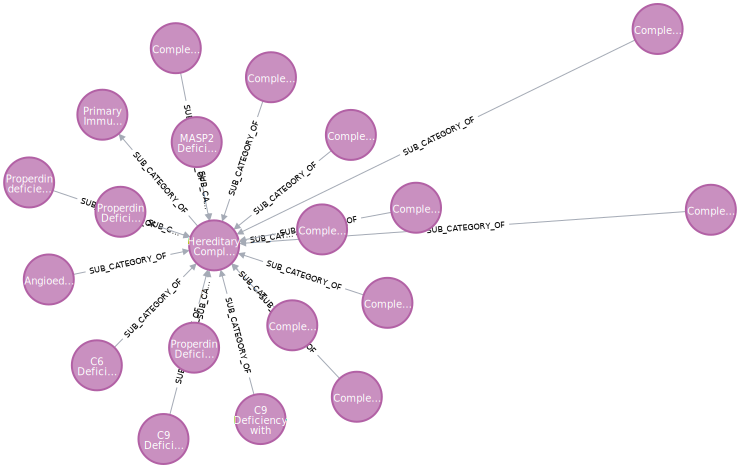

In [228]:
display(SVG(filename='./media/svg/Fig_1_combined_C6_and_C7_deficiencies.svg'))

As we can see, both disease are part of the larger group - "Hereditary Complement Deficiency Diseases" (MESH:D000081208
). Let us try to identify where the predicted diseases from the fulltext and vector indices are.

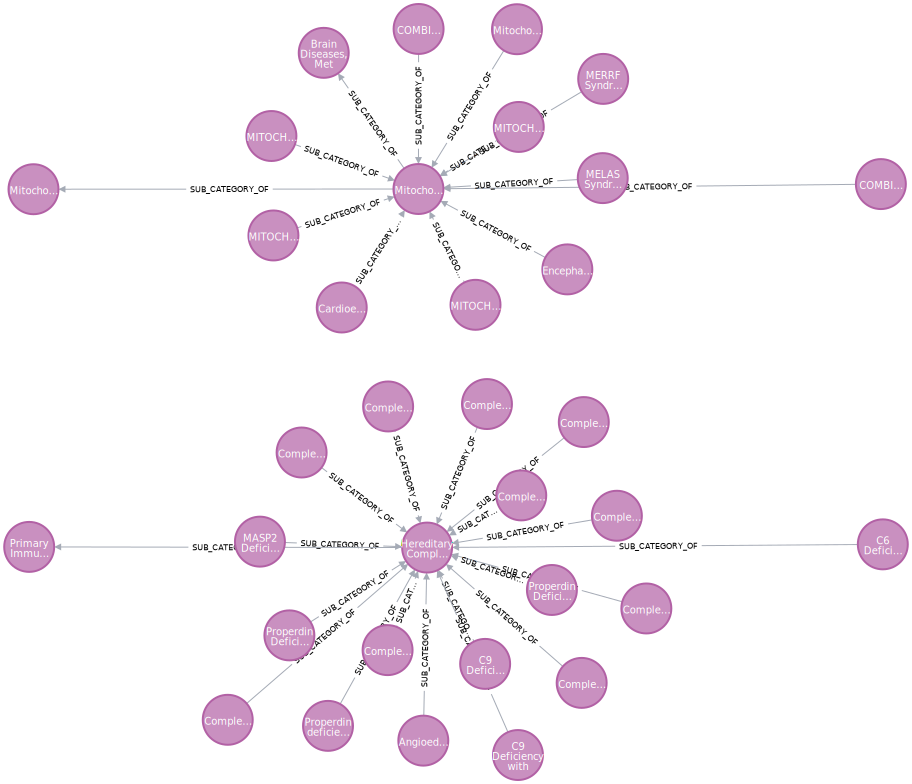

In [230]:
display(SVG(filename='./media/svg/Fig_2_combined_C6_and_C7_deficiencies.svg'))

As we can see, "C6 Deficiency, Subtotal" predicted by fulltext index is still a part of the same group, however, "COMBINED OXIDATIVE PHOSPHORYLATION DEFICIENCY 7" belongs to a different group - "Mitochondrial Encephalomyopathies" (MESH:D017237
), which makes it a worse candidate. Moreover, vector index search produced a different result when the same query was given - "Molybdenum Cofactor Deficiency, Complementation Group C", which belongs to a different from previous two disease groups, which may suggest that vector search works worse for disease names. 
Let us analyze one more prediction - "breast cancer".

In [252]:
get_disease_by_id("MESH:D001943")

[{'DiseaseID': 'MESH:D001943',
  'DiseaseName': 'Breast Neoplasms',
  'AltDiseaseIDs': 'DO:DOID:1612|DO:DOID:3459|OMIM:114480',
  'Synonyms': 'Breast Cancer|BREAST CANCER, FAMILIAL BREAST CANCER, FAMILIAL MALE, INCLUDED|Breast Carcinoma|Breast Carcinomas|Breast Malignant Neoplasm|Breast Malignant Neoplasms|Breast Malignant Tumor|Breast Malignant Tumors|Breast Neoplasm|Breast Tumor|Breast Tumors|Cancer, Breast|Cancer, Mammary|Cancer of Breast|Cancer of the Breast|Cancers, Mammary|Carcinoma, Breast|Carcinoma, Human Mammary|Carcinomas, Breast|Carcinomas, Human Mammary|Human Mammary Carcinoma|Human Mammary Carcinomas|Human Mammary Neoplasm|Human Mammary Neoplasms|Malignant Neoplasm of Breast|Malignant Tumor of Breast|Mammary Cancer|Mammary Cancers|Mammary Carcinoma, Human|Mammary Carcinomas, Human|Mammary Neoplasm, Human|Mammary Neoplasms, Human|Neoplasm, Breast|Neoplasm, Human Mammary|Neoplasms, Breast|Neoplasms, Human Mammary|Tumor, Breast|Tumors, Breast'}]

As we can see, "breast cancer" with "MESH:D001943" can be found as a "Breast Neoplasms" in our knowledge graph, however, "breast cancer" is listed as a synonym. Let us compare the findings for this in our two indices.

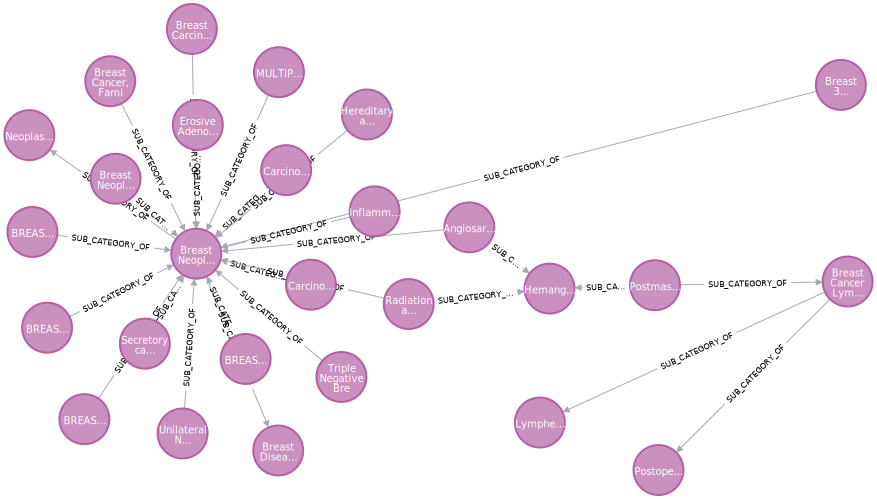

In [254]:
display(SVG(filename='./media/svg/Fig_3_breast_cancer.svg'))

This time the results are different:
- vector index prediction is better, as "Breast cancer 3" belongs to the category of "breast cancer", which was given as a query;
- vector index predicts the same value for the same input this time;
- fulltext index prediction is less accurate, but it is still connected via a different cancer category.

We cannot draw any conclusions just yet, but we can inspect one more aspect. We have written our index search queries with a fallback, so when a query cannot return any results - we get "Unknown" disease. Let us try to count how many unknowns each vector index produced.

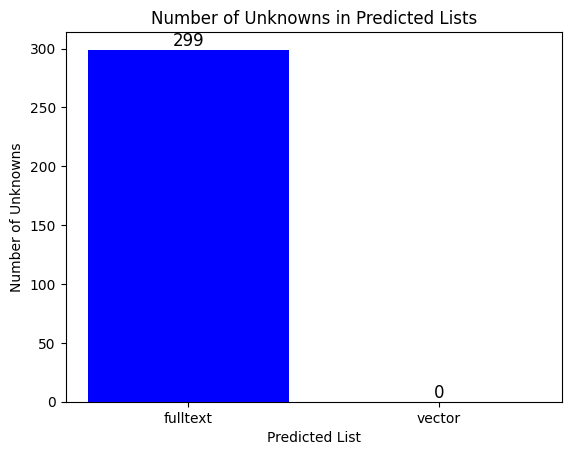

In [266]:
count_unknown_fulltext = sum(1 for item in predicted_values if item[0]['MESH_ID'] == 'Unknown')
count_unknown_vector = sum(1 for item in predicted_values_vector if item[0]['MESH_ID'] == 'Unknown')

labels = ['fulltext', 'vector']
unknown_counts = [count_unknown_fulltext, count_unknown_vector]

bars = plt.bar(labels, unknown_counts, color=['blue', 'orange'])
plt.title('Number of Unknowns in Predicted Lists')
plt.xlabel('Predicted List')
plt.ylabel('Number of Unknowns')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', fontsize=12, color='black')

plt.show()

As we can see, the vector index always returns a value, no matter what input query it receives. It is both a strong side and a weakness of vector indices, and we should establish thresholds for it so the results are more realistic.

Up till this moment the fulltext index had a better performance, but this might be also due to the fact, that we included synonyms in it, whereas our vector index was relying purely on `DiseaseName` property. We identified, that some diseases from the dataset might map to one of the synonyms of the node, rather then its name, so let us experiment with vector index created on synonyms and compare the results.
The `SynonymEmbeddings` property already contains a list of embeddings (one for each synonym in the `Synonyms` property), so we have a few options for how to handle this when creating a vector index:

#### 1. **Create Separate Vector Indexes for Each Synonym Embedding**
   - Treat each embedding in the list as a separate vector and create individual vector indexes for each synonym embedding. This approach can become complex as it might involve creating multiple indexes, which could be cumbersome depending on the number of synonyms.

#### 2. **Combine Synonym Embeddings into a Single Embedding**
   - Combine the list of embeddings into a single embedding vector, which can then be indexed using a single vector index. This can be done by averaging the embeddings, taking the sum, or using a more sophisticated method like weighted averaging or pooling.

#### 3. **Query Using Each Synonym Embedding Separately**
   - When querying, iterate over each embedding in the `SynonymsEmbeddings` list and perform a query for each. Aggregate the results to determine the most relevant entity based on all synonym embeddings.

We will discard the first approach, as it is not scalable.

Since we're going to be using the disease name embeddings for queries, it's worth saving them to the dataset for better performance.

In [206]:
df['DiseaseEmbedding-BAAI-bge-small-en-v1_5'] = df['Description'].apply(lambda text: embed_model.get_text_embedding(text))

In [207]:
df.head()

,ID,Start,End,Description,Type,MESH ID,DiseaseEmbedding-BAAI-bge-small-en-v1_5
0,8808605,376,427,glucose-6-phosphate dehydrogenase (G6PD) defic...,SpecificDisease,MESH:D005955,"[-0.004877162165939808, -0.003928985446691513,..."
1,8808605,572,611,chronic nonspherocytic hemolytic anemia,SpecificDisease,MESH:D000746,"[-0.08520334213972092, 0.050464704632759094, -..."
2,8808605,677,692,G6PD deficiency,SpecificDisease,MESH:D005955,"[0.008812346495687962, -0.038349658250808716, ..."
3,8808605,1368,1383,G6PD deficiency,SpecificDisease,MESH:D005955,"[0.008812346495687962, -0.038349658250808716, ..."
4,9012409,112,149,Duarte enzyme variant of galactosemia,SpecificDisease,MESH:D005693,"[-0.062161244451999664, -0.027829371392726898,..."


In [208]:
df.to_csv('../data/processed/ncbi_specific_disease.csv', sep=',')

## Vector index: combine Synonym embeddings into a single embedding

First of all, we need to combine the synonyms vectors into a new prop on each node. There are nodes without synonyms, so for the sake of completeness, we will duplicate `DiseaseEmbedding` vector into this new property.

In [210]:
create_synonyms_combined_vector_index_query = """
    CREATE VECTOR INDEX baaiVectorIndex_CombinedSynonym IF NOT EXISTS
    FOR (d:Disease)
    ON d.CombinedSynonymEmbedding
    OPTIONS {
        indexConfig: {
            `vector.dimensions`: 384,
            `vector.similarity_function`: 'cosine'
        }
    }
"""

get_synonyms_combined_vector_index_query = """
    CALL db.index.vector.queryNodes('baaiVectorIndex_CombinedSynonym', $query_embedding, $limit)
    YIELD node AS disease, similarity AS score
    RETURN disease.DiseaseName AS Description, disease.DiseaseID AS MESH_ID, disease.AltDiseaseIDs AS AltDiseaseIDs
    ORDER BY score DESC
"""